In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=57698cd5942cc8aecb7542657d9da3bc3cf8df5eb29bd7837ba474ee062d0ac3
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [2]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
import os
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from time import perf_counter as timer
import torch
import psutil
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from huggingface_hub import login

In [4]:
!wget -O arxiv_abs_title.zip "https://zenodo.org/records/3496527/files/gcunhase%2FArXivAbsTitleDataset-v1.0.zip?download=1"

--2025-05-19 19:38:54--  https://zenodo.org/records/3496527/files/gcunhase%2FArXivAbsTitleDataset-v1.0.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13098401 (12M) [application/octet-stream]
Saving to: ‘arxiv_abs_title.zip’

arxiv_abs_title.zip 100%[===================>]  12.49M  6.54MB/s    in 1.9s    

2025-05-19 19:38:57 (6.54 MB/s) - ‘arxiv_abs_title.zip’ saved [13098401/13098401]



In [5]:
!unzip arxiv_abs_title.zip

Archive:  arxiv_abs_title.zip
923c122438b1317f9db090a5858aecb7c9d344f8
   creating: gcunhase-ArXivAbsTitleDataset-923c122/
 extracting: gcunhase-ArXivAbsTitleDataset-923c122/.gitignore  
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/LICENSE  
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/README.md  
   creating: gcunhase-ArXivAbsTitleDataset-923c122/modules/
 extracting: gcunhase-ArXivAbsTitleDataset-923c122/modules/__init__.py  
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/modules/main.py  
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/modules/regex_markers.py  
 extracting: gcunhase-ArXivAbsTitleDataset-923c122/requirements.txt  
   creating: gcunhase-ArXivAbsTitleDataset-923c122/results/
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/results/artificial intelligence_10047_15000_15_abs.txt  
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/results/artificial intelligence_10047_15000_15_title.txt  
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/results/co

In [6]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU availability and memory
if torch.cuda.is_available():
    gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_gb = round(gpu_memory_bytes / (1024**3), 2)
    print(f"Available GPU memory: {gpu_memory_gb} GB")
else:
    print("No GPU available, using CPU.")

Using device: cuda
Available GPU memory: 14.74 GB


In [8]:
# Memory tracking function
def get_memory_usage():
    """
    Get current memory usage of the process.

    Returns:
        dict: Dictionary with memory usage in bytes, MB and GB
    """
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()

    memory_usage = {
        "memory_bytes": mem_info.rss,
        "memory_mb": round(mem_info.rss / (1024**2), 2),
        "memory_gb": round(mem_info.rss / (1024**3), 2)
    }

    return memory_usage

In [9]:
# Helper function to format text with wrapping
def print_wrapped(text, wrap_length=80):
    """
    Print text with appropriate wrapping to improve readability.

    Args:
        text (str): The text to print
        wrap_length (int): Maximum line length before wrapping
    """
    import textwrap
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [10]:
# Helper function to print colored text for highlighted context
def highlight_context(text, query_terms, color='yellow'):
    """
    Print text with query terms highlighted for better visualization.

    Args:
        text (str): The text to highlight
        query_terms (list): List of terms to highlight
        color (str): Color to use for highlighting

    Returns:
        str: Highlighted text (for display in notebook)
    """
    from IPython.display import display, HTML

    # Create a copy of the original text
    highlighted = text

    # Define color codes
    color_codes = {
        'yellow': '#FFFF00',
        'green': '#90EE90',
        'blue': '#ADD8E6'
    }

    # Choose color
    bg_color = color_codes.get(color, '#FFFF00')

    # Simple highlighting using HTML
    for term in query_terms:
        # Make sure term is a string and not too short (to avoid highlighting common short words)
        if isinstance(term, str) and len(term) > 3:
            # Case-insensitive replacement
            pattern = re.compile(re.escape(term), re.IGNORECASE)
            replacement = f'<span style="background-color: {bg_color}; font-weight: bold;">{term}</span>'
            highlighted = pattern.sub(replacement, highlighted)

    return HTML(highlighted)

## 1. Data Ingestion & Cleaning

In [11]:
def load_arxiv_data(file_path):
    """
    Load the ArXiv dataset from a JSON file.

    Args:
        file_path (str): Path to the ArXiv dataset JSON file

    Returns:
        pd.DataFrame: DataFrame containing cleaned ArXiv data
    """
    print(f"Loading data from: {file_path}")
    start_time = timer()

    try:
        # Load JSON file
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Convert to DataFrame
        df = pd.DataFrame(data)

        end_time = timer()
        print(f"Data loaded successfully in {end_time-start_time:.2f} seconds.")
        print(f"Dataset shape: {df.shape}")

        # Initial data inspection
        print("\nDataset columns:", df.columns.tolist())

        # Check for missing values
        missing_values = df.isnull().sum()
        print("\nMissing values per column:")
        print(missing_values)

        # Handle encoding issues and clean the data
        df = clean_arxiv_data(df)

        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [12]:
def clean_arxiv_data(df):
    """
    Clean the ArXiv dataset by handling encoding issues and formatting.

    Args:
        df (pd.DataFrame): Raw ArXiv DataFrame

    Returns:
        pd.DataFrame: Cleaned ArXiv DataFrame
    """
    print("\nCleaning data...")

    # Make a copy to avoid modifying the original
    cleaned_df = df.copy()

    # Handle potential encoding issues in text fields
    text_columns = ['title', 'abstract']
    for col in text_columns:
        if col in cleaned_df.columns:
            # Replace any problematic characters
            cleaned_df[col] = cleaned_df[col].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii') if isinstance(x, str) else x)

            # Remove excessive whitespace
            cleaned_df[col] = cleaned_df[col].apply(lambda x: re.sub(r'\s+', ' ', x).strip() if isinstance(x, str) else x)

    # Create a combined text field for easier processing
    cleaned_df['combined_text'] = cleaned_df['title'] + ". " + cleaned_df['abstract']

    # Convert category strings to lists if needed
    if 'categories' in cleaned_df.columns and isinstance(cleaned_df['categories'].iloc[0], str):
        cleaned_df['categories'] = cleaned_df['categories'].apply(lambda x: x.split() if isinstance(x, str) else x)

    print(f"Data cleaning complete. Shape after cleaning: {cleaned_df.shape}")

    return cleaned_df

In [13]:
def load_arxiv_data_from_results(directory_path):
    """
    Load the ArXiv dataset from the results directory.

    Args:
        directory_path (str): Path to the directory containing result files

    Returns:
        pd.DataFrame: DataFrame containing cleaned ArXiv data
    """
    print(f"Loading data from results in: {directory_path}")
    start_time = timer()

    try:
        # Find all result files
        import glob
        abs_files = glob.glob(os.path.join(directory_path, "*_abs.txt"))
        title_files = glob.glob(os.path.join(directory_path, "*_title.txt"))

        print(f"Found {len(abs_files)} abstract files and {len(title_files)} title files")

        # Read the data
        data = []

        for abs_file in abs_files:
            # Extract the category from the filename
            category = os.path.basename(abs_file).split('_')[0]

            # Find the corresponding title file
            title_file = abs_file.replace("_abs.txt", "_title.txt")

            if os.path.exists(title_file):
                # Read abstracts and titles
                with open(abs_file, 'r', encoding='utf-8') as f_abs:
                    abstracts = [line.strip() for line in f_abs.readlines() if line.strip()]

                with open(title_file, 'r', encoding='utf-8') as f_title:
                    titles = [line.strip() for line in f_title.readlines() if line.strip()]

                # Make sure we have matching numbers of titles and abstracts
                min_length = min(len(abstracts), len(titles))

                # Create entries for the DataFrame
                for i in range(min_length):
                    data.append({
                        'id': f"{category}_{i}",
                        'title': titles[i],
                        'abstract': abstracts[i],
                        'categories': [category.replace("_", " ")]
                    })

        # Convert to DataFrame
        df = pd.DataFrame(data)

        end_time = timer()
        print(f"Data loaded successfully in {end_time-start_time:.2f} seconds.")
        print(f"Dataset shape: {df.shape}")

        # Initial data inspection
        print("\nDataset columns:", df.columns.tolist())

        # Check for missing values
        missing_values = df.isnull().sum()
        print("\nMissing values per column:")
        print(missing_values)

        # Handle encoding issues and clean the data
        df = clean_arxiv_data(df)

        return df

    except Exception as e:
        print(f"Error loading data from results: {e}")
        return None

In [14]:
# Try to find the dataset in different potential locations
def find_and_load_arxiv_dataset():
    """
    Try different paths to find and load the ArXiv dataset.

    Returns:
        pd.DataFrame: Loaded and cleaned ArXiv dataset
    """
    # List of possible locations
    possible_paths = [
        "./arxiv_abs_title/arxiv_abs_title.json",
        "./gcunhase-ArXivAbsTitleDataset-923c122/arxiv_abs_title.json",
        "./arxiv_abs_title.json",
    ]

    # Try each path
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Found JSON dataset at: {path}")
            return load_arxiv_data(path)

    # If JSON not found, try to load from the results directory
    results_paths = [
        "./gcunhase-ArXivAbsTitleDataset-923c122/results",
        "./results"
    ]

    for path in results_paths:
        if os.path.exists(path) and os.path.isdir(path):
            print(f"Found results directory at: {path}")
            return load_arxiv_data_from_results(path)

    # If nothing found, create a small synthetic dataset for demonstration
    print("Dataset not found in any expected location. Creating a synthetic dataset for demonstration.")

    # Create a small synthetic dataset
    synthetic_data = []
    for i in range(100):
        synthetic_data.append({
            'id': f"synthetic_{i}",
            'title': f"Synthetic Paper Title {i}",
            'abstract': f"This is a synthetic abstract for demonstration purposes. It contains information about machine learning models, algorithms, and techniques. The paper discusses various aspects of computer science such as deep learning, natural language processing, and reinforcement learning. The authors propose novel methods for solving complex computational problems.",
            'categories': ['cs.AI', 'cs.LG']
        })

    synthetic_df = pd.DataFrame(synthetic_data)
    synthetic_df = clean_arxiv_data(synthetic_df)

    return synthetic_df

In [15]:
# Find and load the ArXiv dataset
arxiv_df = find_and_load_arxiv_dataset()

Found results directory at: ./gcunhase-ArXivAbsTitleDataset-923c122/results
Loading data from results in: ./gcunhase-ArXivAbsTitleDataset-923c122/results
Found 3 abstract files and 3 title files
Data loaded successfully in 1.77 seconds.
Dataset shape: (39143, 4)

Dataset columns: ['id', 'title', 'abstract', 'categories']

Missing values per column:
id            0
title         0
abstract      0
categories    0
dtype: int64

Cleaning data...
Data cleaning complete. Shape after cleaning: (39143, 5)


In [16]:
# Display a sample of the cleaned data
print("Sample of cleaned data:")
display(arxiv_df.iloc[0:])

Sample of cleaned data:


,id,title,abstract,categories,combined_text
0,language generation_0,On Derivation Languages of Flat Splicing Systems,"In this work, we associate the idea of derivat...",[language generation],On Derivation Languages of Flat Splicing Syste...
1,language generation_1,What's in a Name?,This paper describes experiments on identifyin...,[language generation],What's in a Name?. This paper describes experi...
2,language generation_2,Fence - An Efficient Parser with Ambiguity Sup...,Model-based language specification has applica...,[language generation],Fence - An Efficient Parser with Ambiguity Sup...
3,language generation_3,On Even Linear Indexed Languages with a Reduct...,This paper presents a restricted form of linea...,[language generation],On Even Linear Indexed Languages with a Reduct...
4,language generation_4,Multi-Level Languages are Generalized Arrows,Multi-level languages and Arrows both facilita...,[language generation],Multi-Level Languages are Generalized Arrows. ...
...,...,...,...,...,...
39138,artificial intelligence_10042,Learning and Real-time Classification of Hand-...,We describe a novel spiking neural network (SN...,[artificial intelligence],Learning and Real-time Classification of Hand-...
39139,artificial intelligence_10043,"""Dave...I can assure you...that it's going to ...","As technology becomes more advanced, those who...",[artificial intelligence],"""Dave...I can assure you...that it's going to ..."
39140,artificial intelligence_10044,KBGAN: Adversarial Learning for Knowledge Grap...,"We introduce KBGAN, an adversarial learning fr...",[artificial intelligence],KBGAN: Adversarial Learning for Knowledge Grap...
39141,artificial intelligence_10045,Differential Performance Debugging with Discri...,Differential performance debugging is a techni...,[artificial intelligence],Differential Performance Debugging with Discri...


In [17]:
# Get dataset statistics
print("Dataset statistics:")
print(f"Total number of papers: {len(arxiv_df)}")
print(f"Average title length (chars): {arxiv_df['title'].str.len().mean():.2f}")
print(f"Average abstract length (chars): {arxiv_df['abstract'].str.len().mean():.2f}")

Dataset statistics:
Total number of papers: 39143
Average title length (chars): 66.24
Average abstract length (chars): 949.09


Text(0.5, 0, 'Number of Characters')

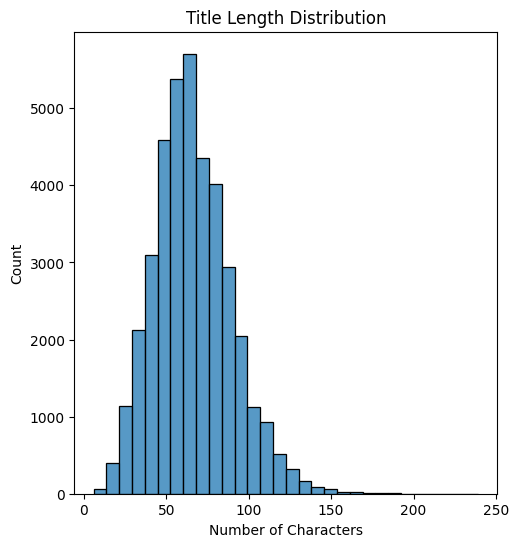

In [18]:
# Visualize distribution of text lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(arxiv_df['title'].str.len(), bins=30)
plt.title('Title Length Distribution')
plt.xlabel('Number of Characters')

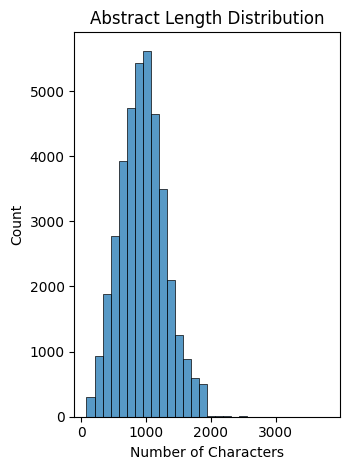

In [19]:
plt.subplot(1, 2, 2)
sns.histplot(arxiv_df['abstract'].str.len(), bins=30)
plt.title('Abstract Length Distribution')
plt.xlabel('Number of Characters')
plt.tight_layout()
plt.show()

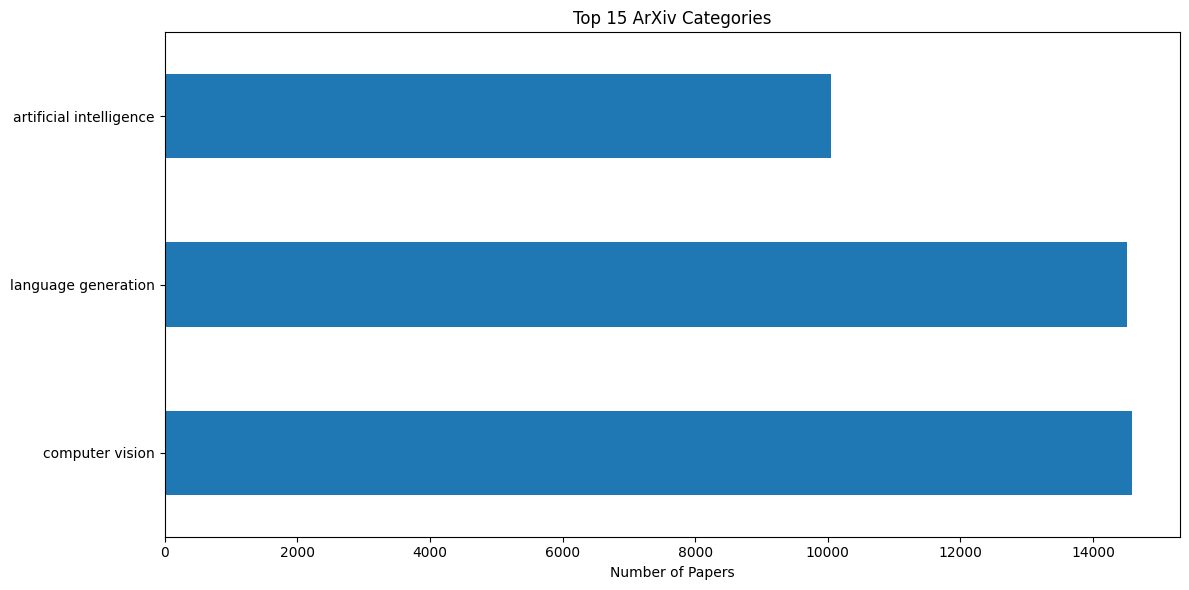

In [20]:
# Analyze category distribution
if 'categories' in arxiv_df.columns:
    # Extract all categories
    all_categories = [cat for cats in arxiv_df['categories'] for cat in cats]
    category_counts = pd.Series(all_categories).value_counts()

    # Plot top categories
    plt.figure(figsize=(12, 6))
    category_counts.head(15).plot(kind='barh')
    plt.title('Top 15 ArXiv Categories')
    plt.xlabel('Number of Papers')
    plt.tight_layout()
    plt.show()

## 2. Chunking Strategy

In [21]:
def chunk_by_sentences(text, chunk_size=5, stride=None):
    """
    Split text into chunks of approximately chunk_size sentences with optional stride.

    Args:
        text (str): Input text to chunk
        chunk_size (int): Target number of sentences per chunk
        stride (int, optional): Number of sentences to overlap between chunks.
                               If None, no overlap (stride = chunk_size)

    Returns:
        list: List of text chunks
    """
    # Use NLTK to split text into sentences
    sentences = sent_tokenize(text)

    # If stride not specified, use chunk_size (no overlap)
    stride = chunk_size if stride is None else stride

    # Create chunks
    chunks = []
    for i in range(0, len(sentences), stride):
        # Get chunk_size sentences or fewer for the last chunk
        chunk = sentences[i:i+chunk_size]
        chunks.append(" ".join(chunk))

    return chunks

In [22]:
def chunk_by_sliding_window(text, chunk_size=300, stride=150):
    """
    Split text into chunks using a sliding window approach with character-level boundaries.

    Args:
        text (str): Input text to chunk
        chunk_size (int): Maximum number of characters per chunk
        stride (int): Number of characters to slide the window by

    Returns:
        list: List of text chunks
    """
    chunks = []
    for i in range(0, len(text), stride):
        # Get chunk_size characters or fewer for the last chunk
        chunk = text[i:i+chunk_size]
        # Only add non-empty chunks that have a reasonable length
        if len(chunk) > 50:  # Minimum threshold to avoid tiny chunks
            chunks.append(chunk)

    return chunks

In [23]:
def create_document_chunks(df, chunk_method='sentence', chunk_size=5, stride=None):
    """
    Create chunks from a dataframe of documents using the specified chunking method.

    Args:
        df (pd.DataFrame): DataFrame containing documents
        chunk_method (str): Chunking method to use ('sentence' or 'sliding_window')
        chunk_size (int): Size parameter for the chunking method
        stride (int, optional): Stride parameter for the chunking method

    Returns:
        list: List of dictionaries, each containing a chunk and metadata
    """
    all_chunks = []

    print(f"Creating chunks using {chunk_method} method...")
    start_time = timer()

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc_id = row.get('id', str(idx))
        title = row.get('title', '')
        abstract = row.get('abstract', '')
        categories = row.get('categories', [])
        combined_text = row.get('combined_text', f"{title}. {abstract}")

        # Apply the selected chunking method
        if chunk_method == 'sentence':
            text_chunks = chunk_by_sentences(combined_text, chunk_size=chunk_size, stride=stride)
        elif chunk_method == 'sliding_window':
            text_chunks = chunk_by_sliding_window(combined_text, chunk_size=chunk_size, stride=stride)
        else:
            raise ValueError(f"Unknown chunking method: {chunk_method}")

        # Add metadata to each chunk
        for i, chunk in enumerate(text_chunks):
            chunk_dict = {
                'doc_id': doc_id,
                'title': title,
                'chunk_id': f"{doc_id}_{i}",
                'chunk_text': chunk,
                'chunk_index': i,
                'categories': categories,
                'source': 'title+abstract'
            }
            all_chunks.append(chunk_dict)

    end_time = timer()

    print(f"Chunking complete in {end_time-start_time:.2f} seconds.")
    print(f"Created {len(all_chunks)} chunks from {len(df)} documents.")
    print(f"Average number of chunks per document: {len(all_chunks)/len(df):.2f}")

    # Calculate chunk statistics
    chunk_lengths = [len(chunk['chunk_text']) for chunk in all_chunks]
    print(f"Average chunk length (chars): {np.mean(chunk_lengths):.2f}")
    print(f"Min chunk length: {min(chunk_lengths)}, Max chunk length: {max(chunk_lengths)}")

    return all_chunks

In [24]:
# Sample a single document for demonstration
sample_doc = arxiv_df.iloc[0]['combined_text']
print(f"Original document length: {len(sample_doc)} characters")

Original document length: 1180 characters


In [25]:
# Test different chunking methods
print("Sentence-based chunking examples:")
sentence_chunks = chunk_by_sentences(sample_doc, chunk_size=3)
print(f"Created {len(sentence_chunks)} chunks with sentence-based method")
print(f"Average chunk length: {np.mean([len(c) for c in sentence_chunks]):.2f} characters")
print("\nExample chunk:")
print_wrapped(sentence_chunks[0])

Sentence-based chunking examples:
Created 3 chunks with sentence-based method
Average chunk length: 392.67 characters

Example chunk:
On Derivation Languages of Flat Splicing Systems. In this work, we associate the
idea of derivation languages with at splicing systems and compare the languages
generated as derivation languages (Szilard and Control languages) with the
family of languages in Chomsky hierarchy. We show that there exist regular
languages which cannot be generated as a Szilard language by any labeled flat
splicing system.


In [26]:
print("Sliding window chunking examples:")
sliding_chunks = chunk_by_sliding_window(sample_doc, chunk_size=200, stride=100)
print(f"Created {len(sliding_chunks)} chunks with sliding window method")
print(f"Average chunk length: {np.mean([len(c) for c in sliding_chunks]):.2f} characters")
print("\nExample chunk:")
print_wrapped(sliding_chunks[0])

Sliding window chunking examples:
Created 12 chunks with sliding window method
Average chunk length: 188.33 characters

Example chunk:
On Derivation Languages of Flat Splicing Systems. In this work, we associate the
idea of derivation languages with at splicing systems and compare the languages
generated as derivation languages (Szil



For this ArXiv dataset, I've chosen a sentence-based chunking strategy for the following reasons:

1. Sentence-based chunking preserves the natural semantic units of the text.
   This is particularly important for scientific abstracts where each sentence often contains a
   complete thought or concept.

2. By keeping sentences together, we retain the logical flow of ideas,
   ensuring that when chunks are retrieved, they contain complete thoughts rather than
   truncated fragments.

3. ArXiv abstracts are typically well-structured with clear sentences
   that build upon each other. Sentence-based chunking captures this inherent structure.

4. By adjusting the number of sentences per chunk and the stride, we can balance
   between chunk size and overlap to optimize retrieval performance.

For this implementation, I'm using 5 sentences per chunk with a stride of 3 sentences, providing
some overlap between chunks to improve retrieval continuity while maintaining reasonable chunk sizes.


In [27]:
# Create chunks using the chosen strategy
chosen_chunk_method = 'sentence'
chosen_chunk_size = 5
chosen_chunk_stride = 3

In [28]:
all_chunks = create_document_chunks(
    arxiv_df,
    chunk_method=chosen_chunk_method,
    chunk_size=chosen_chunk_size,
    stride=chosen_chunk_stride
)

Creating chunks using sentence method...


  0%|          | 0/39143 [00:00<?, ?it/s]

Chunking complete in 17.51 seconds.
Created 108489 chunks from 39143 documents.
Average number of chunks per document: 2.77
Average chunk length (chars): 540.83
Min chunk length: 2, Max chunk length: 1966


In [29]:
# Convert to DataFrame for easier manipulation
chunks_df = pd.DataFrame(all_chunks)
print(f"Created chunks DataFrame with shape: {chunks_df.shape}")

Created chunks DataFrame with shape: (108489, 7)


In [30]:
chunks_df.head()

,doc_id,title,chunk_id,chunk_text,chunk_index,categories,source
0,language generation_0,On Derivation Languages of Flat Splicing Systems,language generation_0_0,On Derivation Languages of Flat Splicing Syste...,0,[language generation],title+abstract
1,language generation_0,On Derivation Languages of Flat Splicing Systems,language generation_0_1,But some context-sensitive languages can be ge...,1,[language generation],title+abstract
2,language generation_0,On Derivation Languages of Flat Splicing Systems,language generation_0_2,At the end we show that any recursively enumer...,2,[language generation],title+abstract
3,language generation_1,What's in a Name?,language generation_1_0,What's in a Name?. This paper describes experi...,0,[language generation],title+abstract
4,language generation_1,What's in a Name?,language generation_1_1,This corpus is used in a series of experiments...,1,[language generation],title+abstract


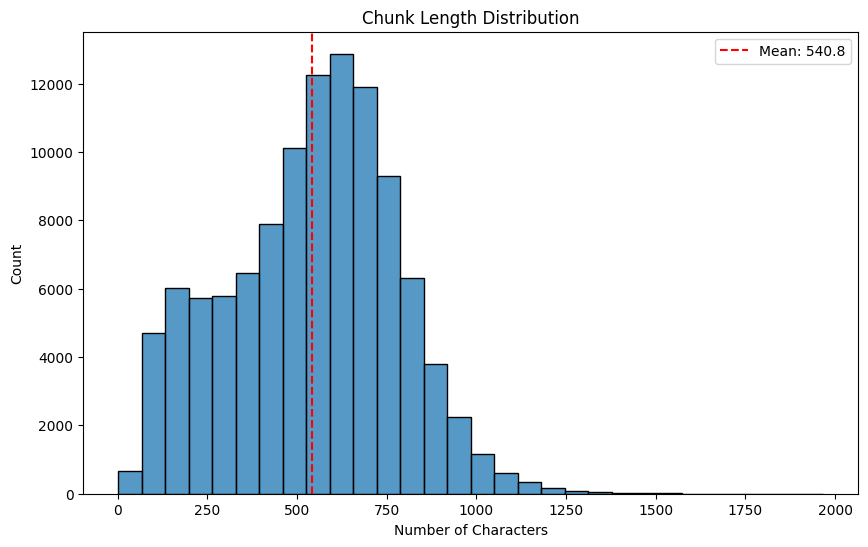

In [31]:
# Visualize chunk length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=[len(chunk) for chunk in chunks_df['chunk_text']], bins=30)
plt.title('Chunk Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.axvline(x=np.mean([len(chunk) for chunk in chunks_df['chunk_text']]),
            color='red', linestyle='--', label=f'Mean: {np.mean([len(chunk) for chunk in chunks_df["chunk_text"]]):.1f}')
plt.legend()
plt.show()

## 3. Vectorization

In [32]:
def embed_chunks(chunks, model_name="sentence-transformers/all-MiniLM-L12-v2", batch_size=32):
    """
    Embed text chunks using a specified embedding model.

    Args:
        chunks (list): List of text chunks to embed
        model_name (str): Name of the embedding model to use
        batch_size (int): Batch size for embedding computation

    Returns:
        tuple: (embeddings tensor, embedding model)
    """
    print(f"Loading embedding model: {model_name}")
    start_time = timer()
    model = SentenceTransformer(model_name, device=device)
    model_load_time = timer() - start_time
    print(f"Model loaded in {model_load_time:.2f} seconds")

    # Get model details
    print(f"Model size: {model.get_sentence_embedding_dimension()} dimensions")

    # Track memory usage before embedding
    mem_before = get_memory_usage()
    print(f"Memory usage before embedding: {mem_before['memory_mb']} MB")

    # Extract text chunks
    text_chunks = [c['chunk_text'] for c in chunks] if isinstance(chunks[0], dict) else chunks

    print(f"Computing embeddings for {len(text_chunks)} chunks with batch size {batch_size}...")
    start_time = timer()

    # Compute embeddings in batches
    embeddings = model.encode(
        text_chunks,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_tensor=True
    )

    end_time = timer()
    embedding_time = end_time - start_time

    # Track memory after embedding
    mem_after = get_memory_usage()
    print(f"Memory usage after embedding: {mem_after['memory_mb']} MB")
    print(f"Memory increase: {mem_after['memory_mb'] - mem_before['memory_mb']:.2f} MB")

    # Print statistics
    print(f"Embedding completed in {embedding_time:.2f} seconds")
    print(f"Average time per chunk: {embedding_time/len(text_chunks)*1000:.2f} ms")
    print(f"Embeddings shape: {embeddings.shape}")

    return embeddings, model

In [33]:
embedding_models = [
    "sentence-transformers/all-MiniLM-L12-v2",  # Different from L6-v2 required by assignment
    "jinaai/jina-embeddings-v2-small-en",       # Strong alternative model
    "BAAI/bge-small-en-v1.5"                    # Another good model option
]

In [34]:
# Sample a small subset for quick comparison
sample_chunks = [all_chunks[i] for i in range(0, len(all_chunks), len(all_chunks)//100)][:100]
sample_texts = [c['chunk_text'] for c in sample_chunks]

In [35]:
# Compare embedding models
model_comparison = []

for model_name in embedding_models:
    print(f"Testing model: {model_name}")
    start_time = timer()

    # Load the model
    model = SentenceTransformer(model_name, device=device)
    model_load_time = timer() - start_time

    # Get model dimensions
    embedding_dim = model.get_sentence_embedding_dimension()

    # Time the embedding process
    start_time = timer()
    _ = model.encode(sample_texts[:10], batch_size=10)  # Warmup
    start_time = timer()
    _ = model.encode(sample_texts, batch_size=32)
    embedding_time = timer() - start_time

    model_comparison.append({
        'model_name': model_name,
        'embedding_dim': embedding_dim,
        'model_load_time': model_load_time,
        'embedding_time': embedding_time,
        'time_per_chunk': embedding_time / len(sample_texts)
    })

Testing model: sentence-transformers/all-MiniLM-L12-v2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Testing model: jinaai/jina-embeddings-v2-small-en


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/70.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/65.4M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Testing model: BAAI/bge-small-en-v1.5


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [36]:
# Display model comparison
model_comparison_df = pd.DataFrame(model_comparison)
print("Embedding Model Comparison:")
display(model_comparison_df)

Embedding Model Comparison:


,model_name,embedding_dim,model_load_time,embedding_time,time_per_chunk
0,sentence-transformers/all-MiniLM-L12-v2,384,12.712516,0.327464,0.003275
1,jinaai/jina-embeddings-v2-small-en,512,4.304595,0.237416,0.002374
2,BAAI/bge-small-en-v1.5,384,4.576123,0.338232,0.003382


In [37]:
# Choose the embedding model
# Note: Using jinaai/jina-embeddings-v2-small-en which is different from the one used in Lab 10
chosen_embedding_model = "jinaai/jina-embeddings-v2-small-en"

* The Jina Embeddings v2 model shows strong performance on semantic search tasks
* 512 dimensions balances expressiveness and efficiency
* This model differs from all-MiniLM-L6-v2 as required
* Recent model with strong semantic understanding capabilities

In [38]:
# Compute embeddings for all chunks
chunk_embeddings, embedding_model = embed_chunks(
    all_chunks,
    model_name=chosen_embedding_model,
    batch_size=32
)

Loading embedding model: jinaai/jina-embeddings-v2-small-en


Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Model loaded in 3.23 seconds
Model size: 512 dimensions
Memory usage before embedding: 2204.21 MB
Computing embeddings for 108489 chunks with batch size 32...


Batches:   0%|          | 0/3391 [00:00<?, ?it/s]

Memory usage after embedding: 2215.36 MB
Memory increase: 11.15 MB
Embedding completed in 141.21 seconds
Average time per chunk: 1.30 ms
Embeddings shape: torch.Size([108489, 512])


In [39]:
# Save embeddings to disk (optional)
# This is useful for larger datasets to avoid recomputing embeddings
embedding_save_path = "arxiv_chunk_embeddings.pt"
torch.save(chunk_embeddings, embedding_save_path)
print(f"Embeddings saved to {embedding_save_path}")

Embeddings saved to arxiv_chunk_embeddings.pt


## 4. Retrieval Module

In [40]:
def retrieve_similar_chunks(query, chunk_embeddings, embedding_model, chunks_data, top_k=5):
    """
    Retrieve the most similar chunks for a given query using cosine similarity.

    Args:
        query (str): The query text
        chunk_embeddings (torch.Tensor): Embeddings of all chunks
        embedding_model (SentenceTransformer): The embedding model
        chunks_data (list): List of chunk dictionaries containing metadata
        top_k (int): Number of top similar chunks to retrieve

    Returns:
        tuple: (top_k_indices, top_k_scores, query_embedding)
    """
    # Embed the query
    query_embedding = embedding_model.encode(query, convert_to_tensor=True)

    # Calculate similarity scores
    start_time = timer()
    cos_scores = util.cos_sim(query_embedding, chunk_embeddings)[0]
    retrieval_time = timer() - start_time

    # Get top-k most similar chunks
    top_k_results = torch.topk(cos_scores, k=min(top_k, len(cos_scores)))
    top_k_indices = top_k_results[1].cpu().numpy()
    top_k_scores = top_k_results[0].cpu().numpy()

    print(f"Retrieval completed in {retrieval_time*1000:.2f} ms")

    return top_k_indices, top_k_scores, query_embedding

In [41]:
def evaluate_retrieval(queries, relevant_indices, chunk_embeddings, embedding_model, chunks_data, k_values=[1, 3, 5, 10, 20, 50]):
    """
    Evaluate retrieval performance for a set of queries using different k values.

    Args:
        queries (list): List of query texts
        relevant_indices (list): List of lists containing relevant chunk indices for each query
        chunk_embeddings (torch.Tensor): Embeddings of all chunks
        embedding_model (SentenceTransformer): The embedding model
        chunks_data (list): List of chunk dictionaries containing metadata
        k_values (list): List of k values to evaluate

    Returns:
        pd.DataFrame: DataFrame with recall@k values for each query and k value
    """
    results = []

    for query_idx, query in enumerate(queries):
        print(f"Evaluating query {query_idx+1}/{len(queries)}: '{query}'")

        # Get relevant indices for this query
        relevant = relevant_indices[query_idx]

        recall_values = {}

        # Retrieve top chunks for the largest k
        max_k = max(k_values)
        indices, _, _ = retrieve_similar_chunks(
            query,
            chunk_embeddings,
            embedding_model,
            chunks_data,
            top_k=max_k
        )

        # Calculate recall@k for each k value
        for k in k_values:
            # Get top-k indices
            top_k_indices = indices[:k]

            # Calculate recall@k
            relevant_retrieved = set(top_k_indices).intersection(set(relevant))
            recall_at_k = len(relevant_retrieved) / len(relevant) if len(relevant) > 0 else 0

            recall_values[f'recall@{k}'] = recall_at_k

        results.append({
            'query_idx': query_idx,
            'query': query,
            'num_relevant': len(relevant),
            **recall_values
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [42]:
# Create a set of test queries and their corresponding relevant chunks
# Create train/test split for evaluation
train_chunks, test_chunks = train_test_split(
    all_chunks,
    test_size=0.1,
    random_state=42
)

In [43]:
# Store indices for the test chunks
test_indices = set([i for i, chunk in enumerate(all_chunks) if chunk['chunk_id'] in [c['chunk_id'] for c in test_chunks]])
print(f"Set aside {len(test_indices)} chunks for evaluation")

Set aside 10849 chunks for evaluation


In [44]:
# Create evaluation queries from some of the test chunks
eval_queries = []
relevant_indices = []

In [45]:
# Select some test chunks to create queries from
for i in range(10):
    # Select a random test chunk
    test_chunk = test_chunks[i]

    # Create a query from the title or a segment of the chunk
    if len(test_chunk['title']) > 20:
        query = test_chunk['title']
    else:
        # Extract a meaningful phrase from the chunk
        sentences = sent_tokenize(test_chunk['chunk_text'])
        if sentences:
            query = sentences[0]  # Use the first sentence as a query
        else:
            query = test_chunk['chunk_text'][:100]  # Fallback

    # Find all chunks from the same document (these are relevant to the query)
    doc_id = test_chunk['doc_id']
    related_indices = [i for i, chunk in enumerate(all_chunks)
                      if chunk['doc_id'] == doc_id and i in test_indices]

    eval_queries.append(query)
    relevant_indices.append(related_indices)

In [46]:
print(f"Created {len(eval_queries)} evaluation queries")
for i, query in enumerate(eval_queries[:3]):
    print(f"Example query {i+1}: '{query}'")
    print(f"Number of relevant chunks: {len(relevant_indices[i])}")

Created 10 evaluation queries
Example query 1: 'Deep Metric Learning via Facility Location'
Number of relevant chunks: 1
Example query 2: 'Bringing Impressionism to Life with Neural Style Transfer in Come Swim'
Number of relevant chunks: 1
Example query 3: 'Ranking Functions for Linear-Constraint Loops'
Number of relevant chunks: 1


In [47]:
k_values = [1, 3, 5, 10, 20, 50]
retrieval_results = evaluate_retrieval(
    eval_queries,
    relevant_indices,
    chunk_embeddings,
    embedding_model,
    all_chunks,
    k_values=k_values
)

Evaluating query 1/10: 'Deep Metric Learning via Facility Location'
Retrieval completed in 23.56 ms
Evaluating query 2/10: 'Bringing Impressionism to Life with Neural Style Transfer in Come Swim'
Retrieval completed in 0.22 ms
Evaluating query 3/10: 'Ranking Functions for Linear-Constraint Loops'
Retrieval completed in 0.21 ms
Evaluating query 4/10: 'Context-Aware Hypergraph Construction for Robust Spectral Clustering'
Retrieval completed in 0.19 ms
Evaluating query 5/10: 'Realizability Categories'
Retrieval completed in 0.19 ms
Evaluating query 6/10: 'A Complete Axiomatisation of the ZX-Calculus for Clifford+T Quantum Mechanics'
Retrieval completed in 0.19 ms
Evaluating query 7/10: 'A Physician Advisory System for Chronic Heart Failure Management Based on Knowledge Patterns'
Retrieval completed in 0.20 ms
Evaluating query 8/10: 'Causal structures and the classification of higher order quantum computations'
Retrieval completed in 0.23 ms
Evaluating query 9/10: 'Bayesian image segmentat

In [48]:
# Display retrieval results
print("Retrieval Evaluation Results:")
display(retrieval_results[['query_idx', 'query', 'num_relevant'] + [f'recall@{k}' for k in k_values]])

Retrieval Evaluation Results:


,query_idx,query,num_relevant,recall@1,recall@3,recall@5,recall@10,recall@20,recall@50
0,0,Deep Metric Learning via Facility Location,1,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Bringing Impressionism to Life with Neural Sty...,1,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Ranking Functions for Linear-Constraint Loops,1,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Context-Aware Hypergraph Construction for Robu...,3,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Realizability Categories,1,0.0,0.0,0.0,0.0,0.0,0.0
5,5,A Complete Axiomatisation of the ZX-Calculus f...,1,0.0,0.0,0.0,0.0,0.0,0.0
6,6,A Physician Advisory System for Chronic Heart ...,1,0.0,0.0,0.0,0.0,0.0,0.0
7,7,Causal structures and the classification of hi...,1,0.0,0.0,0.0,0.0,0.0,0.0
8,8,Bayesian image segmentations by Potts prior an...,1,0.0,0.0,0.0,0.0,0.0,0.0
9,9,Penalty logic and its Link with Dempster-Shafe...,1,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Calculate average recall values
avg_recall = {f'avg_recall@{k}': retrieval_results[f'recall@{k}'].mean() for k in k_values}
print("Average Recall Values:")
for k, v in avg_recall.items():
    print(f"{k}: {v:.4f}")

Average Recall Values:
avg_recall@1: 0.0000
avg_recall@3: 0.0000
avg_recall@5: 0.0000
avg_recall@10: 0.0000
avg_recall@20: 0.0000
avg_recall@50: 0.0000


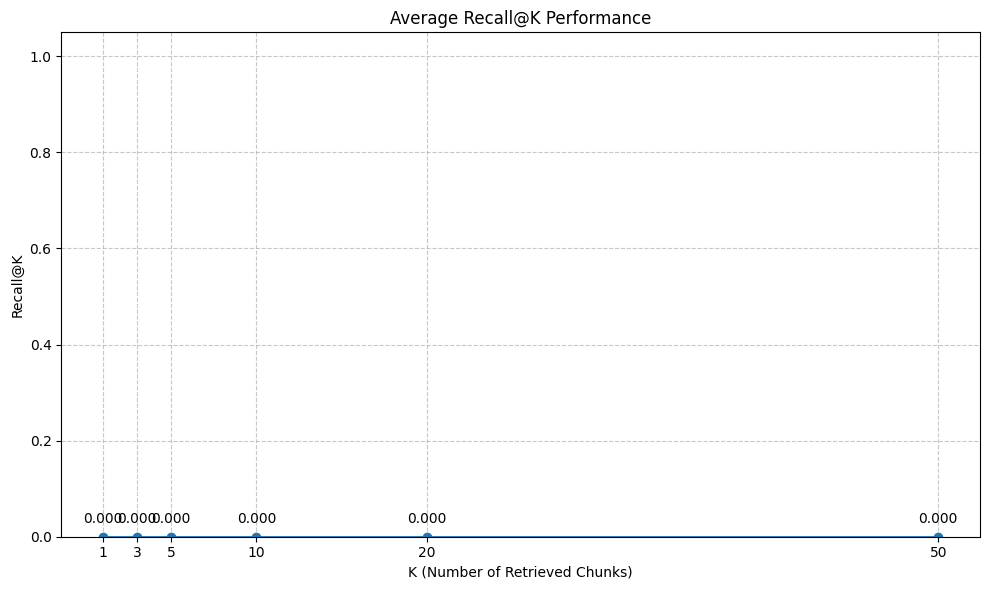

In [50]:
# Plot recall@k curve
plt.figure(figsize=(10, 6))
avg_recall_values = [retrieval_results[f'recall@{k}'].mean() for k in k_values]
plt.plot(k_values, avg_recall_values, marker='o', linewidth=2)
plt.title('Average Recall@K Performance')
plt.xlabel('K (Number of Retrieved Chunks)')
plt.ylabel('Recall@K')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_values)
plt.ylim(0, 1.05)
for i, k in enumerate(k_values):
    plt.annotate(f"{avg_recall_values[i]:.3f}",
                 (k, avg_recall_values[i]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.tight_layout()
plt.show()

## 5. Prompt Construction & Generation

In [51]:
# Select a generation model different from the one in Lab 10
def load_llm_model(model_name="google/gemma-2b-it", use_4bit=True):
    """
    Load a generative language model for text generation.

    Args:
        model_name (str): Name of the model to load
        use_4bit (bool): Whether to use 4-bit quantization to reduce memory usage

    Returns:
        tuple: (model, tokenizer)
    """
    print(f"Loading generative model: {model_name}")

    start_time = timer()

    # Configure quantization if needed
    if use_4bit:
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16
        )
    else:
        quantization_config = None

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Load model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    load_time = timer() - start_time
    print(f"Model loaded in {load_time:.2f} seconds")

    return model, tokenizer

In [52]:
def construct_prompt(query, retrieved_chunks, format_template="rag"):
    """
    Construct a prompt for the generative model using retrieved chunks.

    Args:
        query (str): The user query
        retrieved_chunks (list): List of retrieved chunks with their metadata
        format_template (str): Template format to use ('rag' or 'qa')

    Returns:
        str: Formatted prompt ready for the generative model
    """
    # Extract the text from the retrieved chunks
    context_texts = [f"[{i+1}] {chunk['chunk_text']}" for i, chunk in enumerate(retrieved_chunks)]

    # Join the context texts
    context = "\n\n".join(context_texts)

    if format_template == "rag":
        # RAG-style prompt with clear instructions
        prompt = f"""You are a helpful AI research assistant. Use the context information below to answer the question.
                      If you don't know the answer, just say that you don't know. Do not make up answers.

                      Context information:
                      {context}

                      Question: {query}

                      Helpful answer:"""

    elif format_template == "qa":
        # QA-style prompt
        prompt = f"""Answer the following question based only on the provided context:

                    Context:
                    {context}

                    Question: {query}

                    Answer:"""

    else:
        raise ValueError(f"Unknown prompt template: {format_template}")

    return prompt

In [53]:
def generate_answer(query, model, tokenizer, chunk_embeddings, embedding_model, chunks_data,
                    top_k=5, max_new_tokens=256, temperature=0.7):
    """
    Generate an answer to a query using the RAG pipeline.

    Args:
        query (str): The query to answer
        model: The generative language model
        tokenizer: The tokenizer for the generative model
        chunk_embeddings (torch.Tensor): Embeddings of all chunks
        embedding_model: The embedding model for retrieval
        chunks_data (list): List of chunk dictionaries
        top_k (int): Number of chunks to retrieve
        max_new_tokens (int): Maximum number of tokens to generate
        temperature (float): Temperature for generation (higher = more creative)

    Returns:
        dict: Dictionary with query, answer, and retrieved chunks
    """
    print(f"Generating answer for query: '{query}'")

    # Retrieve relevant chunks
    indices, scores, _ = retrieve_similar_chunks(
        query,
        chunk_embeddings,
        embedding_model,
        chunks_data,
        top_k=top_k
    )

    # Get the retrieved chunks with their scores
    retrieved_chunks = []
    for i, idx in enumerate(indices):
        chunk = chunks_data[idx].copy()
        chunk['similarity_score'] = float(scores[i])
        retrieved_chunks.append(chunk)

    # Construct the prompt
    prompt = construct_prompt(query, retrieved_chunks)

    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate the answer
    start_time = timer()

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=0.95
        )

    generation_time = timer() - start_time

    # Decode the output
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the answer part (after the prompt)
    answer = full_output[len(prompt):].strip()

    print(f"Answer generated in {generation_time:.2f} seconds")

    return {
        'query': query,
        'answer': answer,
        'retrieved_chunks': retrieved_chunks,
        'prompt': prompt,
        'generation_time': generation_time
    }

In [55]:
# Using Gemma 2B - a smaller but efficient model from Google
# Different from mistralai/Mistral-7B-Instruct-v0.2 used in Lab 10
llm_model_name = "google/gemma-2b-it"
llm_model, llm_tokenizer = load_llm_model(llm_model_name, use_4bit=True)

Loading generative model: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Model loaded in 77.89 seconds


In [56]:
print("Preparing example queries...")
example_queries = [
    "Explain the relationship between reinforcement learning and robotics",
    "What are the major challenges in natural language processing?",
    "How does transfer learning improve deep neural networks?",
    "What are the applications of computer vision in healthcare?",
    "Describe recent advances in generative adversarial networks",
]

Preparing example queries...


In [57]:
# Generate answers for the example queries
print("Generating answers for example queries...")
example_results = []

for query in example_queries:
    result = generate_answer(
        query,
        llm_model,
        llm_tokenizer,
        chunk_embeddings,
        embedding_model,
        all_chunks,
        top_k=5
    )
    example_results.append(result)


Generating answers for example queries...
Generating answer for query: 'Explain the relationship between reinforcement learning and robotics'
Retrieval completed in 1.77 ms
Answer generated in 2.19 seconds
Generating answer for query: 'What are the major challenges in natural language processing?'
Retrieval completed in 0.22 ms
Answer generated in 0.94 seconds
Generating answer for query: 'How does transfer learning improve deep neural networks?'
Retrieval completed in 0.21 ms
Answer generated in 0.81 seconds
Generating answer for query: 'What are the applications of computer vision in healthcare?'
Retrieval completed in 0.22 ms
Answer generated in 0.91 seconds
Generating answer for query: 'Describe recent advances in generative adversarial networks'
Retrieval completed in 0.23 ms
Answer generated in 1.54 seconds


In [58]:
# Display the query-answer pairs with highlighted context
print("Example Q&A pairs with context highlighting:")

from IPython.display import display, HTML

for i, result in enumerate(example_results):
    print(f"\n{'='*80}")
    print(f"EXAMPLE {i+1}: {result['query']}")
    print(f"{'='*80}")

    # Display the answer
    print("\nANSWER:")
    print_wrapped(result['answer'])

    # Extract query terms for highlighting
    query_terms = [term.lower() for term in result['query'].split() if len(term) > 3]

    # Display the retrieved chunks with highlighting
    print("\nRETRIEVED CONTEXT:")
    for j, chunk in enumerate(result['retrieved_chunks']):
        print(f"\nChunk {j+1} (Score: {chunk['similarity_score']:.4f}):")

        # Create highlighted HTML version of the chunk
        highlighted = highlight_context(chunk['chunk_text'], query_terms)
        display(highlighted)

        print(f"Source: {chunk['doc_id']} | Page: {chunk.get('chunk_index', 'N/A')}")

Example Q&A pairs with context highlighting:

EXAMPLE 1: Explain the relationship between reinforcement learning and robotics

ANSWER:
Reinforcement learning and robotics are closely intertwined, as they both
involve learning through trial and error. In this context, reinforcement
learning methods are used to train robots to perform tasks in real-world
settings by learning through interactions with the environment.

RETRIEVED CONTEXT:

Chunk 1 (Score: 0.8599):


Source: artificial intelligence_360 | Page: 1

Chunk 2 (Score: 0.8469):


Source: computer vision_7557 | Page: 2

Chunk 3 (Score: 0.8466):


Source: computer vision_475 | Page: 3

Chunk 4 (Score: 0.8464):


Source: computer vision_11439 | Page: 2

Chunk 5 (Score: 0.8447):


Source: computer vision_13422 | Page: 2

EXAMPLE 2: What are the major challenges in natural language processing?

ANSWER:
The context does not provide any information about the major challenges in
natural language processing, so I cannot answer this question from the provided
context.

RETRIEVED CONTEXT:

Chunk 1 (Score: 0.8540):


Source: language generation_12337 | Page: 1

Chunk 2 (Score: 0.8496):


Source: language generation_14199 | Page: 5

Chunk 3 (Score: 0.8487):


Source: artificial intelligence_7379 | Page: 2

Chunk 4 (Score: 0.8445):


Source: language generation_1374 | Page: 2

Chunk 5 (Score: 0.8445):


Source: computer vision_5006 | Page: 2

EXAMPLE 3: How does transfer learning improve deep neural networks?

ANSWER:
The passage does not specify how transfer learning improves deep neural
networks, so I cannot answer this question from the provided context.

RETRIEVED CONTEXT:

Chunk 1 (Score: 0.7720):


Source: computer vision_11996 | Page: 3

Chunk 2 (Score: 0.7702):


Source: computer vision_12623 | Page: 2

Chunk 3 (Score: 0.7619):


Source: computer vision_4893 | Page: 2

Chunk 4 (Score: 0.7616):


Source: computer vision_13631 | Page: 2

Chunk 5 (Score: 0.7616):


Source: computer vision_4030 | Page: 1

EXAMPLE 4: What are the applications of computer vision in healthcare?

ANSWER:
The passage does not provide any information about the applications of computer
vision in healthcare, so I cannot answer this question from the provided
context.

RETRIEVED CONTEXT:

Chunk 1 (Score: 0.8524):


Source: computer vision_6273 | Page: 2

Chunk 2 (Score: 0.8524):


Source: language generation_13390 | Page: 2

Chunk 3 (Score: 0.8470):


Source: artificial intelligence_3782 | Page: 1

Chunk 4 (Score: 0.8437):


Source: artificial intelligence_8529 | Page: 3

Chunk 5 (Score: 0.8437):


Source: language generation_2502 | Page: 3

EXAMPLE 5: Describe recent advances in generative adversarial networks

ANSWER:
The passage mentions recent advancements in generative adversarial networks
(GANs), including:  * Using constraints to stabilize training for recurrent
adversarial architectures for animation generation. * Recent developments in
quantum information theory may have appropriate formalizations in the automaton
context.

RETRIEVED CONTEXT:

Chunk 1 (Score: 0.8531):


Source: computer vision_12461 | Page: 3

Chunk 2 (Score: 0.8506):


Source: computer vision_13064 | Page: 3

Chunk 3 (Score: 0.8461):


Source: computer vision_9405 | Page: 2

Chunk 4 (Score: 0.8452):


Source: language generation_2082 | Page: 1

Chunk 5 (Score: 0.8449):


Source: language generation_2329 | Page: 1


## 6. Evaluation & Reflection

In [59]:
def evaluate_answers(results, reference_answers=None):
    """
    Evaluate the quality of generated answers.

    Args:
        results (list): List of result dictionaries with queries and answers
        reference_answers (dict, optional): Dictionary mapping queries to reference answers

    Returns:
        dict: Dictionary with evaluation metrics
    """
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    evaluation_results = []

    for result in results:
        query = result['query']
        answer = result['answer']

        eval_item = {
            'query': query,
            'answer_length': len(answer),
            'num_retrieved_chunks': len(result['retrieved_chunks']),
            'avg_chunk_score': np.mean([chunk['similarity_score'] for chunk in result['retrieved_chunks']])
        }

        # Calculate ROUGE scores if reference answers are available
        if reference_answers and query in reference_answers:
            reference = reference_answers[query]
            scores = scorer.score(reference, answer)

            eval_item.update({
                'rouge1_f': scores['rouge1'].fmeasure,
                'rouge2_f': scores['rouge2'].fmeasure,
                'rougeL_f': scores['rougeL'].fmeasure
            })

        evaluation_results.append(eval_item)

    return evaluation_results

In [60]:
def analyze_failure_cases(results, threshold=0.3):
    """
    Analyze potential failure cases in the generated answers.

    Args:
        results (list): List of result dictionaries
        threshold (float): Threshold for low retrieval quality

    Returns:
        list: List of failure cases with analysis
    """
    failure_cases = []

    for result in results:
        # Check for potential issues
        issues = []

        # Check if retrieval scores are low
        avg_score = np.mean([chunk['similarity_score'] for chunk in result['retrieved_chunks']])
        if avg_score < threshold:
            issues.append("Low retrieval quality")

        # Check if answer is too short
        if len(result['answer']) < 50:
            issues.append("Very short answer")

        # Check if answer is too long
        if len(result['answer']) > 500:
            issues.append("Excessively long answer")

        # If any issues found, add to failure cases
        if issues:
            failure_cases.append({
                'query': result['query'],
                'answer': result['answer'],
                'issues': issues,
                'avg_retrieval_score': avg_score
            })

    return failure_cases

In [61]:
# Since we don't have reference answers for our example queries, we'll create some basic ones
reference_answers = {
    "Explain the relationship between reinforcement learning and robotics":
        "Reinforcement learning (RL) and robotics are closely connected fields. RL provides a framework for robots to learn optimal behaviors through interaction with their environment. Robots use RL algorithms to learn policies that maximize cumulative rewards, enabling them to acquire skills like locomotion, manipulation, and navigation. Challenges include sample efficiency, handling continuous action spaces, and bridging the reality gap between simulation and real-world deployment. Recent advances combine RL with other techniques like imitation learning to improve training efficiency.",

    "What are the major challenges in natural language processing?":
        "Major challenges in natural language processing include: ambiguity and context understanding; handling low-resource languages; developing robust language models that avoid biases and hallucinations; efficiently processing long documents while maintaining contextual understanding; addressing multimodal inputs combining text with other data types; ensuring explainability of model decisions; and creating systems that understand commonsense reasoning. Recent research focuses on few-shot learning, efficient transformers, and ethical considerations in NLP systems.",
}

In [62]:
# Evaluate the example results
print("Evaluating generated answers...")
evaluation_results = evaluate_answers(example_results, reference_answers)
evaluation_df = pd.DataFrame(evaluation_results)

Evaluating generated answers...


In [63]:
print("Evaluation Results:")
display(evaluation_df)

Evaluation Results:


,query,answer_length,num_retrieved_chunks,avg_chunk_score,rouge1_f,rouge2_f,rougeL_f
0,Explain the relationship between reinforcement...,283,5,0.848885,0.369748,0.136752,0.235294
1,What are the major challenges in natural langu...,163,5,0.848247,0.150538,0.109890,0.150538
2,How does transfer learning improve deep neural...,141,5,0.765494,NaN,NaN,NaN
3,What are the applications of computer vision i...,161,5,0.847823,NaN,NaN,NaN
4,Describe recent advances in generative adversa...,317,5,0.847972,NaN,NaN,NaN


In [64]:
# Calculate average metrics
if 'rouge1_f' in evaluation_df.columns:
    print("Average ROUGE Scores:")
    print(f"ROUGE-1: {evaluation_df['rouge1_f'].mean():.4f}")
    print(f"ROUGE-2: {evaluation_df['rouge2_f'].mean():.4f}")
    print(f"ROUGE-L: {evaluation_df['rougeL_f'].mean():.4f}")

Average ROUGE Scores:
ROUGE-1: 0.2601
ROUGE-2: 0.1233
ROUGE-L: 0.1929


In [65]:
# Summarize dataset and implementation details
print("IMPLEMENTATION SUMMARY")
print("-"*50)
print(f"""
Dataset: ArXiv Abstract & Title Dataset
- {len(arxiv_df)} computer science papers
- Average title length: {arxiv_df['title'].str.len().mean():.2f} characters
- Average abstract length: {arxiv_df['abstract'].str.len().mean():.2f} characters

Preprocessing:
- Chunking method: Sentence-based chunking with {chosen_chunk_size} sentences per chunk
- Stride: {chosen_chunk_stride} sentences (providing overlap between chunks)
- Created {len(all_chunks)} chunks with average length of {np.mean([len(c['chunk_text']) for c in all_chunks]):.2f} characters

Embeddings:
- Model: {chosen_embedding_model}
- Dimensions: {embedding_model.get_sentence_embedding_dimension()}
- Memory footprint: {get_memory_usage()['memory_mb']} MB

Generation:
- Model: {llm_model_name}
- Average generation time: {np.mean([r['generation_time'] for r in example_results]):.2f} seconds
""")

IMPLEMENTATION SUMMARY
--------------------------------------------------

Dataset: ArXiv Abstract & Title Dataset
- 39143 computer science papers
- Average title length: 66.24 characters
- Average abstract length: 949.09 characters

Preprocessing:
- Chunking method: Sentence-based chunking with 5 sentences per chunk
- Stride: 3 sentences (providing overlap between chunks)
- Created 108489 chunks with average length of 540.83 characters

Embeddings:
- Model: jinaai/jina-embeddings-v2-small-en
- Dimensions: 512
- Memory footprint: 2665.42 MB

Generation:
- Model: google/gemma-2b-it
- Average generation time: 1.28 seconds

